In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.special as spec
import scipy.stats as stats
from scipy import interpolate
from astropy.table import Table

In [2]:
# This plot style module is provided by Dr. Ting-Wan Lan
def my_plot_style():
    params = {'legend.fontsize': 15,
    'axes.labelsize': 15,
    'axes.titlesize':15,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'xtick.major.size':5,
    'xtick.minor.size':2.5,
    'ytick.major.size':5,
    'ytick.minor.size':2.5,
    'figure.facecolor':'w',
    #'lines.linewidth' : 1.5,
    'xtick.major.width':1.5,
    'ytick.major.width':1.5,
    'xtick.minor.width':1.5,
    'ytick.minor.width':1.5,
    'axes.linewidth':1.5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'ytick.labelleft':True,
    'text.usetex' : False,
    'font.family': 'sans-serif'}
plt.rcParams.update(params)
my_plot_style()

### Problem 1.
I first define some functions:

`cal_cdf` : Give a probability distribution function with (x,f(x)) where f(x) is the probability in the interval [x,x+dx], the function will calculate and return the cumulative probability distribution function.

`sample` : Give a numerical probability distribution function with (x,f(x)), and the size of sampling `n`, the function will return n numbers sample from the given PDF.

`plot_pdf` : Give a sample set, this function will plot the normalized probability distribution of this sample set.

In [3]:
def cal_cdf(x,fx):
    binsize = x[1]-x[0]
    cdf = [np.trapz(fx[:i],dx=binsize) for i in range(1,1+len(x))]
    return cdf
def sample(x,fx,n):
    s    = np.random.uniform(0,1,n)
    cdf  = cal_cdf(x,fx)
    f = interpolate.interp1d(cdf, x, fill_value='extrapolate')
    samp = f(s)
    return samp
def plot_pdf(sample,bins=30,binsize=-1):
    hist, bedge = np.histogram(sample,bins=bins)
    bedges = (bedge[1:]+bedge[:-1])/2.0
    if(binsize<0): binsize = bedge[1]-bedge[0]
    return bedges, hist/np.sum(hist)/binsize

To varify the above function, I test them with gaussian.

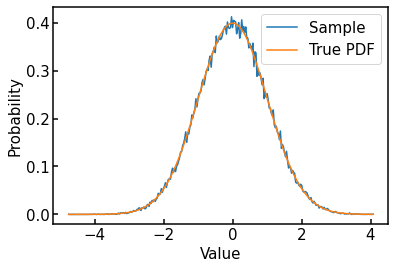

In [4]:
dx     = 1e-1
xrange = np.arange(-5,5,dx)
n      = int(1e5)
mu     = 0
sigma  = 1
pdf    = lambda x,mu,sigma:np.exp(-0.5*((x-mu)/sigma)**2.0)/sigma/(2*np.pi)**0.5

samp = sample(xrange,pdf(xrange,mu,sigma),n)
x, y = plot_pdf(samp,bins=300)
plt.plot(x,y,label='Sample')
plt.plot(x,pdf(x,mu,sigma),label='True PDF')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()

For a non-trivial probability distribution, I test the code with exponential distribution.

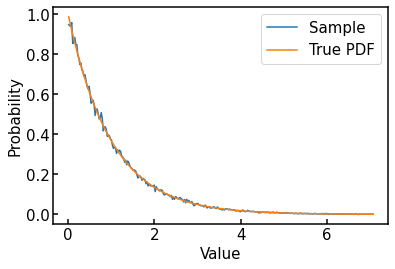

In [5]:
dx     = 1e-1
xrange = np.arange(0,10,dx)
lam    = 1
n      = int(1e5)
pdf    = lambda x,lam:lam*np.exp(-lam*x)

samp = sample(xrange,pdf(xrange,lam),n)
x, y = plot_pdf(samp,bins=300)
plt.plot(x,y,label='Sample')
plt.plot(x,pdf(x,lam),label='True PDF')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.show()

The Salpeter function is defined by $\phi_m(x)\propto m^{-2.35}$. I choose to sample it between 1-100 $M_\odot$. As a result, I first normalize the Salpeter function between this interval to get the PDF, than use my sampling function to sample from the Salpeter function.

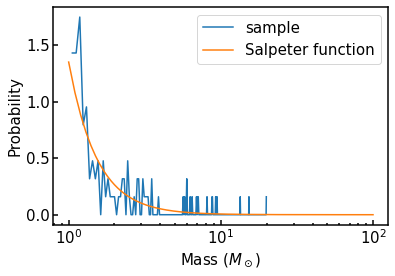

In [6]:
dx       = 1e-1
xrange   = np.arange(1,100,dx)
n        = int(1e2)
salpeter = lambda x:x**(-2.35)
pdf      = lambda x:salpeter(x)/np.trapz(salpeter(x),dx=dx)

samp = sample(xrange,pdf(xrange),n)
x, y = plot_pdf(samp,bins=300)
plt.semilogx(x,y,label='sample')
plt.semilogx(xrange,pdf(xrange),label='Salpeter function')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Probability')
plt.legend()
plt.show()

### Problem 2.
The `GAIA_Messier22.fits` should be located at the same dictionary with this jupyter notebook. Some of the code in this section is provided by the `GAIA sample notebook` provided by Sean Johnson.

In [7]:
# given array (x,y), find points within a circle centered at center.
def find_circle(x,y,center='median'):
    points = np.array([x,y])
    if( center=='median' ): center = np.median(points,axis=1)
    else: center = center
    dr = np.sqrt(np.sum((points-center[:,np.newaxis])**2.0,axis=0))
    return center, dr

In [8]:
m22 = Table.read('GAIA_Messier22.fits')

#### 1. Plot the data with RA/Dec, labeled by parallax. 
In this plot, I also label the region that close to the cluster center (by eye).

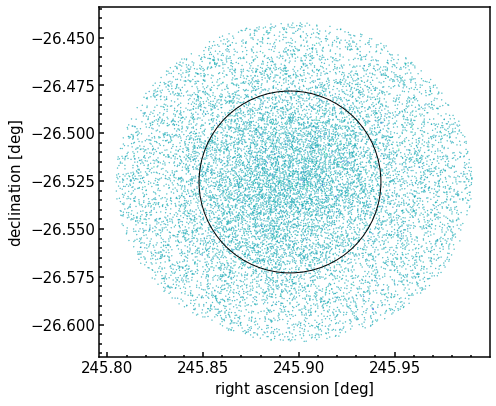

In [9]:
dis_center, dis_dr = find_circle(m22['ra'],m22['dec'])
fig, ax = plt.subplots(1, figsize=(7,7))
cir = plt.Circle(dis_center,0.5*max(dis_dr),fill=False)
ax.scatter(m22['ra'], m22['dec'], c=m22['parallax'], s=0.1, alpha=1,cmap='winter')
ax.set_aspect('equal', 'box')
ax.add_patch(cir)
ax.minorticks_on()
ax.set_ylabel(r'$\rm declination\ [deg]$')
ax.set_xlabel(r'$\rm right\ ascension\ [deg]$')
fig.tight_layout()

#### 2. Plot the Parallax v.s. proper motion
I also labeled the region for sample selection later (by eye).

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


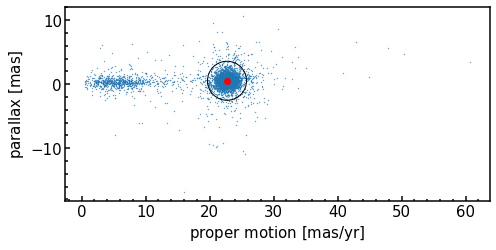

In [10]:
center, dr = find_circle(m22['pm'],m22['parallax'])
fig, ax = plt.subplots(1, figsize=(7,7))
cir = plt.Circle(center,0.08*max(dr),fill=False)
ax.scatter(m22['pm'],m22['parallax'], s=0.1, alpha=1,cmap='magma')
ax.plot(np.median(m22['pm']),np.median(m22['parallax']),c='red',marker='o')
ax.add_patch(cir)
ax.set_aspect('equal', 'box')
ax.minorticks_on()
ax.set_xlabel(r'$\rm proper\ motion\ [mas/yr]$')
ax.set_ylabel(r'$\rm parallax\ [mas]$')
fig.tight_layout()

#### 3. Select sample with proper motion-parallax and angular seperation.
In this section, I required the parallax should be positive to get rid of noises. `m22_new` would be the selected sample.

In [11]:
boolean1 = dis_dr<0.5*max(dis_dr)
boolean2 = (dr<0.08*max(dr))&(m22['parallax']>0)
sample = boolean1&boolean2
m22_new = m22[sample]
m22_bool2 = m22[boolean2]

#### 4. Plot the apparent G-band mag v.s. BP-RP with selected sample.
In this figure, I overplot the origin sample, sample that only selected by parallax/proper motion condition and the sample selected by both separation and parallax/proper motion conditions. It seems that it is the angular separation criteria that mainly eliminate the effect of limit in g-band observation.

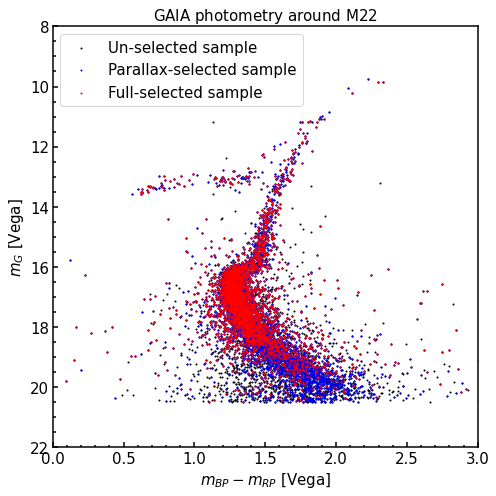

In [12]:
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.scatter(m22['phot_bp_mean_mag'] - m22['phot_rp_mean_mag'], m22['phot_g_mean_mag'], \
           s=1, color='black',label='Un-selected sample')
ax.scatter(m22_bool2['phot_bp_mean_mag'] - m22_bool2['phot_rp_mean_mag'], m22_bool2['phot_g_mean_mag'], \
           s=1, color='blue',label='Parallax-selected sample')
ax.scatter(m22_new['phot_bp_mean_mag'] - m22_new['phot_rp_mean_mag'], m22_new['phot_g_mean_mag'],\
           s=1, color='red',label='Full-selected sample')
ax.set_xlim([0, 3])
ax.set_ylim([22, 8])
ax.set_title(r'$\rm GAIA\ photometry\ around\ M22$')
ax.set_xlabel(r'$m_{BP} - m_{RP}\ [{\rm Vega}]$')
ax.set_ylabel(r'$m_{G}\ [{\rm Vega}]$')
ax.legend()
ax.minorticks_on()
fig.tight_layout()

#### 5. Plot the absolute G-band mag v.s. BP-RP with selected sample and label key components.
I use equation (2.4) in Schneider(2015) to calculate the distance, and equation under section 2.2.4 to calculate the absolute magnitude.

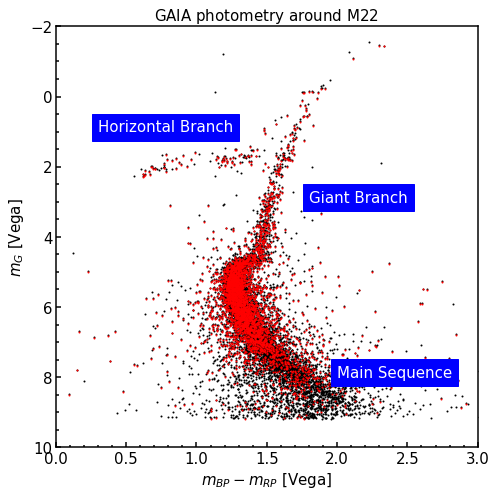

In [13]:
dist      = np.median(1/(abs(m22['parallax'])*0.001))
samp_dist = np.median(1/(abs(m22_new['parallax'])*0.001))
M_g = m22['phot_g_mean_mag']-5*np.log10(dist)+5
samp_M_g = m22_new['phot_g_mean_mag']-5*np.log10(samp_dist)+5

fig, ax = plt.subplots(1, figsize=(7, 7))
ax.scatter(m22['phot_bp_mean_mag'] - m22['phot_rp_mean_mag'], M_g, s=1, color='black')
ax.scatter(m22_new['phot_bp_mean_mag'] - m22_new['phot_rp_mean_mag'], samp_M_g, s=1, color='red')

ax.set_xlim([0, 3])
ax.set_ylim([10, -2])
ax.set_title(r'$\rm GAIA\ photometry\ around\ M22$')
ax.set_xlabel(r'$m_{BP} - m_{RP}\ [{\rm Vega}]$')
ax.set_ylabel(r'$m_{G}\ [{\rm Vega}]$')
plt.text(2.0,8,'Main Sequence',backgroundcolor='blue',c='white',fontsize=15)
plt.text(1.8,3,'Giant Branch',backgroundcolor='blue',c='white',fontsize=15)
plt.text(0.3,1,'Horizontal Branch',backgroundcolor='blue',c='white',fontsize=15)


ax.minorticks_on()
fig.tight_layout()